In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from scipy import signal
from numpy.random import default_rng
from scipy import stats

import importlib
import sys
import os
sys.path.append(os.path.abspath(
    "/Users/roboboy/Documents/GitHub/thztools/src/thztools"))
import thztools as thz
importlib.reload(thz)
%matplotlib inline

In [2]:
n_sim = 16
n = 256

dt = 0.05
t0 = 2.5 
fs = 1/dt

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2  # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3  # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])


seed = 0  # RNG seed
rng = default_rng(seed)

In [3]:
mu = thz.wave(n=n, dt=dt, t0=t0)
t = np.arange(0,n*dt,dt)
noise_mod = thz.NoiseModel(sigma_alpha, sigma_beta, sigma_tau, dt)
sigma = noise_mod.noise_amp(mu)

# Use broadcasting to generate multiple simulated noisy measurements of y
x = mu + sigma * rng.standard_normal((n_sim, n))

# Compute power spectral density
f, psd = signal.periodogram(x, fs=fs, detrend=False)
n_f = f.size

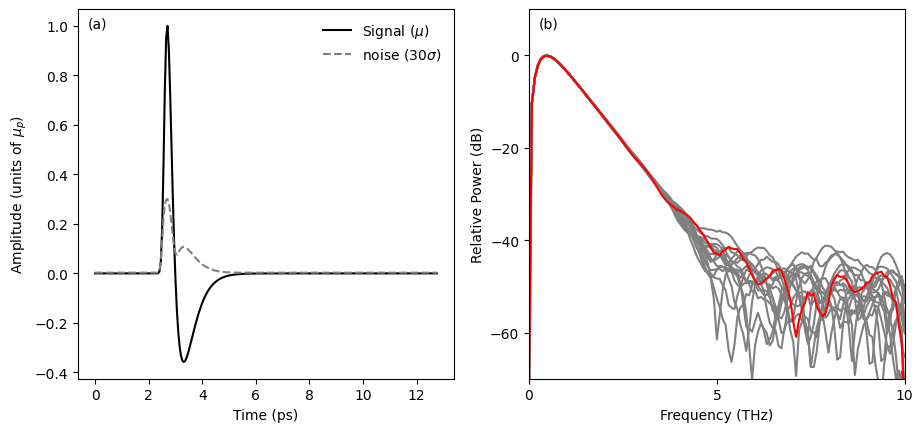

In [4]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot(t, mu, c='k', label=r'Signal ($\mu$)')
axs[0].plot(t, sigma * 30, ls='--', c='grey', label=r'noise $(30 \sigma$)')

axs[0].legend(frameon=False)
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlabel('Time (ps)')
axs[0].set_ylabel(r'Amplitude (units of $\mu_{p})$')

axs[1].plot(f, 10 * np.log10(psd[1:, :].T / max(psd.flatten())), c='grey')
axs[1].plot(f, 10 * np.log10(psd[0, :].T / max(psd.flatten())), c='red')

axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlabel('Frequency (THz)')
axs[1].set_ylabel('Relative Power (dB)')

axs[1].set_xticks(np.arange(0, 11, 5))
axs[1].set_xlim(0, 10)
axs[1].set_yticks(np.arange(-60, 10, 20))
axs[1].set_ylim(-70, 10)

plt.show()
del x

In [5]:
n_sim = 1024
m = 16
n_p = 3

In [6]:
rng = default_rng(seed)

amp = np.empty((n, m, n_sim))
amp_noise = np.empty((n, m, n_sim))

sigma_mu = noise_mod.noise_amp(mu)

for i in range(n_sim):
    seed = i  # RNG seed
    rng = default_rng(seed)
    amp_noise[:,:, i] = (sigma_mu * rng.standard_normal((n, m)).T).T
    amp[:,:,i] = (mu + amp_noise[:,:,i].T).T



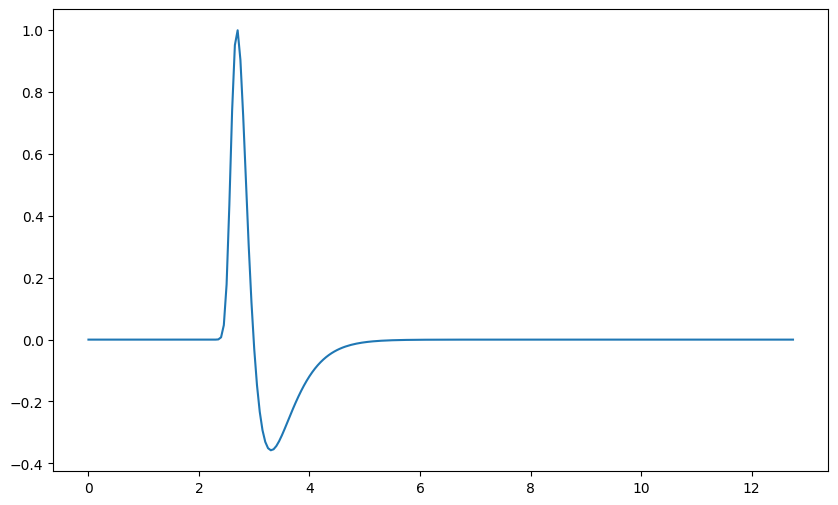

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(t, mu)
plt.show()

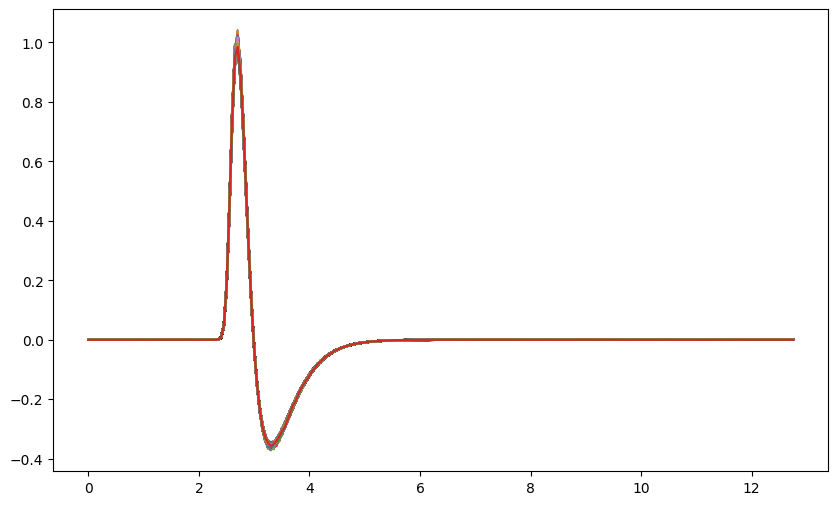

In [8]:
plt.figure(figsize=(10, 6))
for i in range(n_sim):
    for j in range (m):
        plt.plot(t, amp[:, j, i])
plt.show()

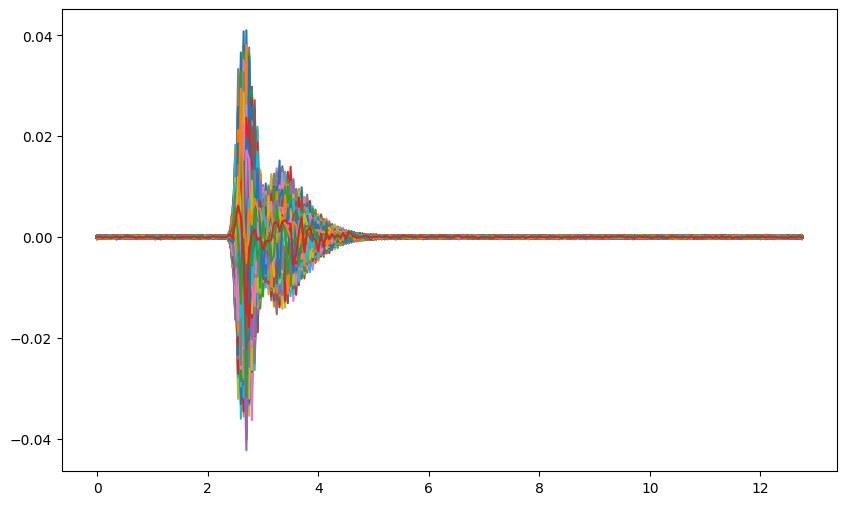

In [9]:
plt.figure(figsize=(10, 6))
for i in range(n_sim):
    for j in range(m):
        plt.plot(t, amp_noise[:, j,i])
plt.show()

In [10]:
# Creating empty arrays to store the fit results
sigma_fit = np.empty((n_p, n_sim))
mu_fit = np.empty((n, n_sim))
sigma_sigma_fit = np.empty((n_p, n_sim))
sigma_mu_fit = np.empty((n, n_sim))
resnorm_tls = np.empty(n_sim)

In [11]:
for i in range(n_sim):
    # print(i)
    noise_fit = thz.noisefit(amp[:,:,i], sigma_alpha0=sigma_alpha, sigma_beta0=sigma_beta, sigma_tau0=sigma_tau,
                             fix_sigma_alpha=False, fix_sigma_beta=False, fix_sigma_tau=False, fix_a=True, fix_eta=True, dt=dt)
    sigma_fit[:,i] = [noise_fit.noise_model.sigma_alpha, noise_fit.noise_model.sigma_beta, noise_fit.noise_model.sigma_tau]
    sigma_sigma_fit[:,i] = [noise_fit.err_sigma_alpha, noise_fit.err_sigma_beta, noise_fit.err_sigma_tau]
    mu_fit [:, i] = noise_fit.mu
    sigma_mu_fit[:,i] = noise_fit.err_mu
    resnorm_tls[i] = noise_fit.fval

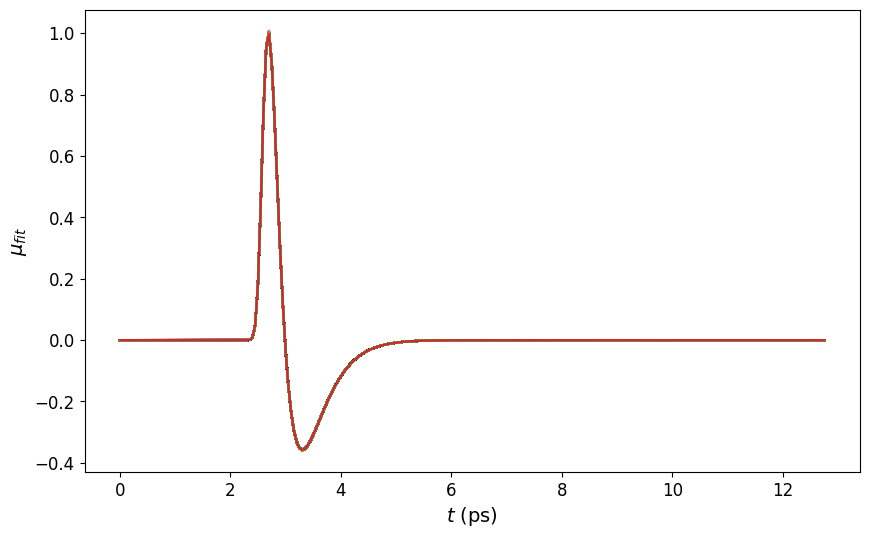

In [12]:
plt.figure(figsize=(10,  6))
for i in range(n_sim):
    plt.plot(t, mu_fit[:,  i])

plt.ylabel('$\mu_{fit}$', fontsize=14)
plt.xlabel("$t$ (ps)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

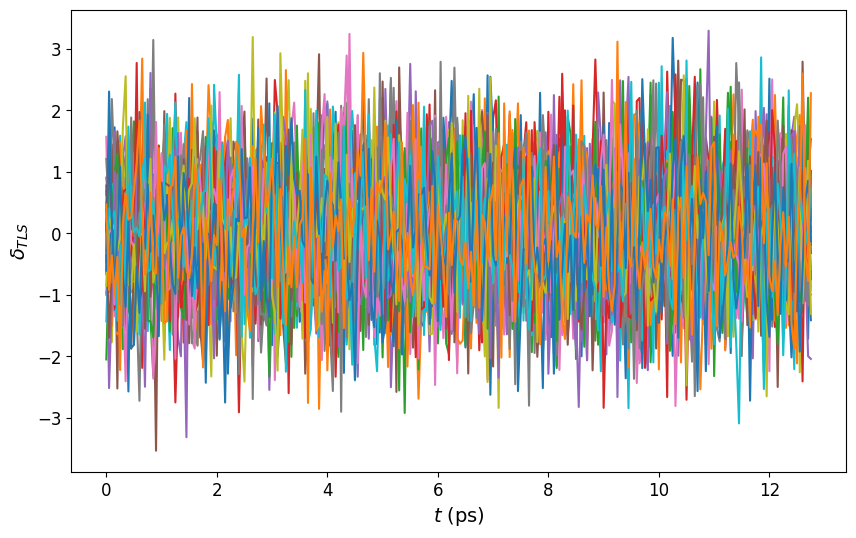

In [13]:
plt.figure(figsize=(10,  6))
for i in range(2):
    for j in range(m):
        res_temp = (amp[:,j,i] - mu_fit[:,i])/noise_mod.noise_amp(amp[:,j,i])
        plt.plot(t, res_temp)
plt.ylabel('$\delta_{TLS}$', fontsize=14)
plt.xlabel("$t$ (ps)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

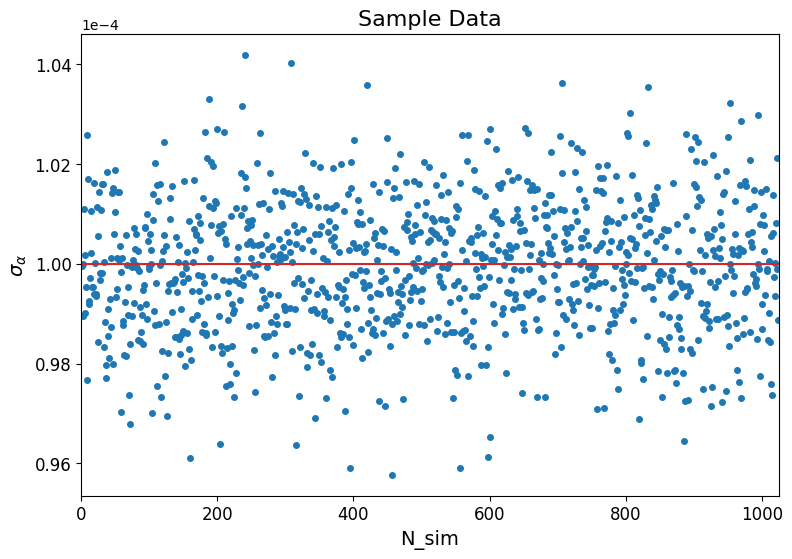

In [14]:
n_sim_arr = np.arange(1,  n_sim+1 , 1)
plt.figure(figsize=(9,  6))
plt.plot(n_sim_arr, sigma_fit[0,:]*np.sqrt(m/(m-1)), 'o', markersize=4)
plt.hlines(sigma_alpha, 0, n_sim+1, colors='C3')
plt.title("Sample Data", fontsize=16)
plt.ylabel('$\sigma_{\\alpha}$', fontsize=14)
plt.xlabel("N_sim", fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,  n_sim+1)
# plt.ylim(0.9e-4,1.1e-4)
plt.show()

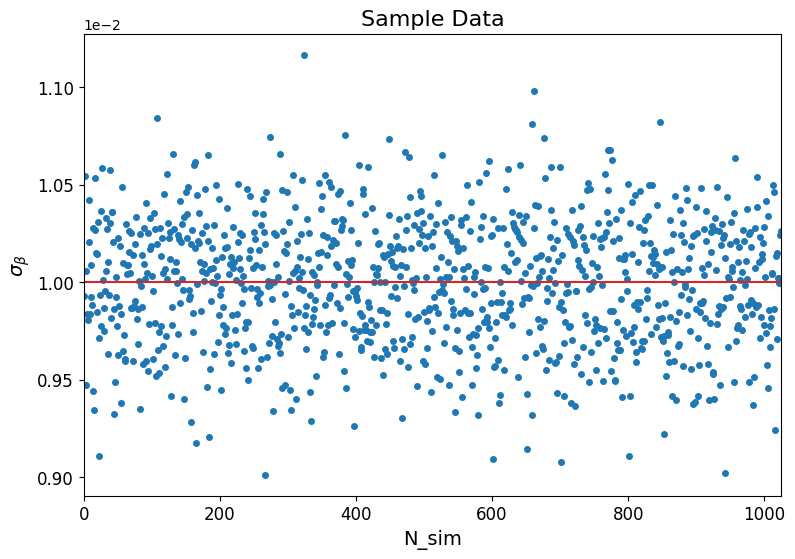

In [15]:
n_sim_arr = np.arange(1,  n_sim+1 , 1)
plt.figure(figsize=(9,  6))
plt.plot(n_sim_arr, sigma_fit[1,:]*np.sqrt(m/(m-1)), 'o', markersize=4)
plt.hlines(sigma_beta, 0, n_sim+1, colors='C3')
plt.title("Sample Data", fontsize=16)
plt.ylabel('$\sigma_{\\beta}$', fontsize=14)
plt.xlabel("N_sim", fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,  n_sim+1)
# plt.ylim(0.9e-2,1.1e-2)
plt.show()

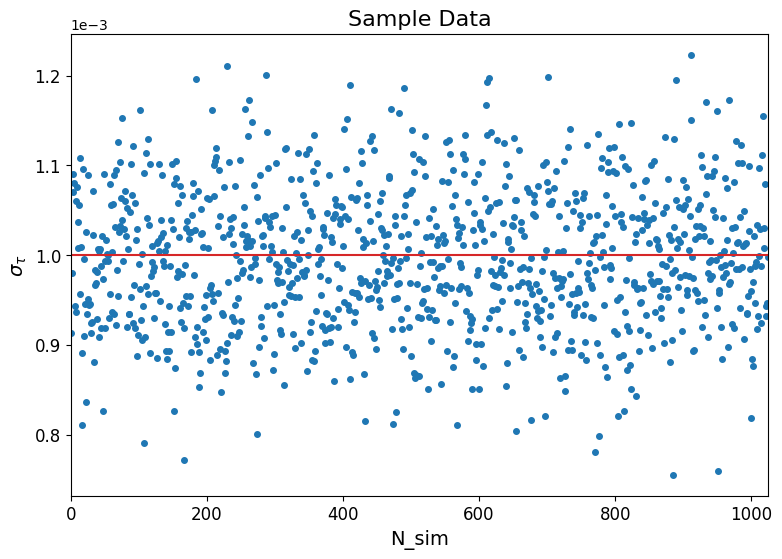

In [16]:
n_sim_arr = np.arange(1,  n_sim+1 , 1)
plt.figure(figsize=(9,  6))
plt.plot(n_sim_arr, sigma_fit[2,:]*np.sqrt(m/(m-1)), 'o', markersize=4)
plt.hlines(sigma_tau, 0, n_sim+1, colors='C3')
plt.title("Sample Data", fontsize=16)
plt.ylabel('$\sigma_{\\tau}$', fontsize=14)
plt.xlabel("N_sim", fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,  n_sim+1)
# plt.ylim(0e-2,3e-2)
plt.show()

In [17]:
print('Actual value of $sigma_alpha$ = {0:.2E}'.format(sigma_alpha))
print('Mean of $sigma_alpha$ = {0:.2E}'.format(np.mean(sigma_fit[0, :]*np.sqrt(m/(m-1)))))
print('Stdev of $sigma_alpha$ = {0:.2E}'.format(np.std(sigma_fit[0, :]*np.sqrt(m/(m-1)))))
print('Mean uncertainty estimate of $sigma_alpha$ = {0:.2E}'.format(
    np.mean(sigma_sigma_fit[0,:]*np.sqrt(m/(m-1)))))
print()
print('Actual value of $sigma_beta$ = {0:.2E}'.format(sigma_beta))
print('Mean of $sigma_beta$ = {0:.2E}'.format(np.mean(sigma_fit[1, :]*np.sqrt(m/(m-1)))))
print('Stdev of $sigma_beta$ = {0:.2E}'.format(np.std(sigma_fit[1, :]*np.sqrt(m/(m-1)))))
print('Mean uncertainty estimate of $sigma_beta$ = {0:.2E}'.format(
    np.mean(sigma_sigma_fit[1,:]*np.sqrt(m/(m-1)))))
print()
print('Actual value of $sigma_tau$ = {0:.2E}'.format(sigma_tau))
print('Mean of $sigma_tau$ = {0:.2E}'.format(np.mean(sigma_fit[2, :]*np.sqrt(m/(m-1)))))
print('Stdev of $sigma_tau$ = {0:.2E}'.format(np.std(sigma_fit[2, :]*np.sqrt(m/(m-1)))))
print('Mean uncertainty estimate of $sigma_tau$ = {0:.2E}'.format(
    np.mean(sigma_sigma_fit[2,:]*np.sqrt(m/(m-1)))))

Actual value of $sigma_alpha$ = 1.00E-04
Mean of $sigma_alpha$ = 9.99E-05
Stdev of $sigma_alpha$ = 1.31E-06
Mean uncertainty estimate of $sigma_alpha$ = 7.57E-05

Actual value of $sigma_beta$ = 1.00E-02
Mean of $sigma_beta$ = 9.99E-03
Stdev of $sigma_beta$ = 3.18E-04
Mean uncertainty estimate of $sigma_beta$ = 1.20E-02

Actual value of $sigma_tau$ = 1.00E-03
Mean of $sigma_tau$ = 9.96E-04
Stdev of $sigma_tau$ = 7.72E-05
Mean uncertainty estimate of $sigma_tau$ = 8.20E-03


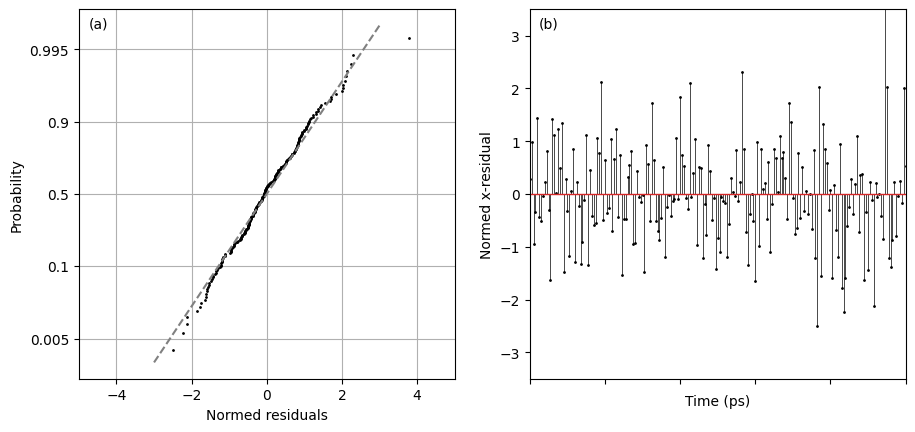

In [18]:
# Find the index of the median value
i_show = np.argsort(resnorm_tls)[len(resnorm_tls) // 2]
j_show = np.random.randint(1, m)
norm_res_delta = np.sqrt((m*n) / ((m-1)*n-n_p))*(amp[:,j_show,i_show] - mu_fit[:,i_show])/noise_mod.noise_amp(amp[:,j_show,i_show])
osm, osr = stats.probplot(
    norm_res_delta, fit=False
)

w, h = figaspect(0.45)
_, axd = plt.subplot_mosaic(
    [["Prob", "x-res"]], figsize=(w, h)
)

# Panel (a)
axd["Prob"].plot(osr, osm, 'k.', ms=2)
axd["Prob"].plot([-3, 3], [-3, 3], '--', c='gray')

axd["Prob"].grid()


axd["Prob"].text(0.025, 0.95, '(a)', transform=axd["Prob"].transAxes)

axd["Prob"].set_xlim(-5, 5)
axd["Prob"].set_ylim(stats.norm.ppf([0.0005, 0.9995]))

axd["Prob"].set_xticks(np.arange(-4, 4.5, 2))
axd["Prob"].set_yticks(stats.norm.ppf([0.005, 0.1, 0.5, 0.9, 0.995]))

axd["Prob"].set_yticklabels(['0.005', '0.1', '0.5', '0.9', '0.995'])

axd["Prob"].set_xlabel('Normed residuals')
axd["Prob"].set_ylabel('Probability')


# Panel (b)
markerline, stemlines, baseline = axd["x-res"].stem(
    t, norm_res_delta, linefmt='k-', markerfmt='.'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["x-res"].text(0.025, 0.95, '(b)', transform=axd["x-res"].transAxes)

axd["x-res"].set_xlim(0, 10)
axd["x-res"].set_ylim(-3.5, 3.5)

axd["x-res"].set_xticklabels([])
axd["x-res"].set_xlabel('Time (ps)')
axd["x-res"].set_ylabel('Normed x-residual')

plt.show()